In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

import time, os
from tqdm import tqdm

In [2]:
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm, AffineConstantFlow, LinearFlow
from nflib.coupling_flows import AffineHalfFlow, MLP_Generator, DimensionMixer
from nflib.res_flow import ResidualFlow, ReLU, LeakyReLU, Swish, ResidualFlow3
##### Linear units are worst, use swish type activation

In [3]:
import nflib

In [4]:
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform

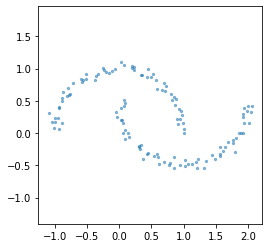

In [5]:
# Lightweight datasets
import pickle
from sklearn import datasets

class DatasetMoons:
    """ two half-moons """
    def sample(self, n):
        moons = datasets.make_moons(n_samples=n, noise=0.05)[0].astype(np.float32)
        return torch.from_numpy(moons)

class DatasetMixture:
    """ 4 mixture of gaussians """
    def sample(self, n):
        assert n%4 == 0
        r = np.r_[np.random.randn(n // 4, 2)*0.5 + np.array([0, -2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([0, 0]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([2, 2]),
                  np.random.randn(n // 4, 2)*0.5 + np.array([-2, 2])]
        return torch.from_numpy(r.astype(np.float32))

d = DatasetMoons()
#d = DatasetMixture()
#d = DatasetSIGGRAPH()

x = d.sample(128)
plt.figure(figsize=(4,4))
plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
plt.axis('equal');

In [6]:
prior = MultivariateNormal(torch.zeros(2), torch.eye(2))

flows = []
hidden_dims = [24, 24, 24]
# generator = MLP_Generator([24,24,24])
for i in range(16):
#     a = AffineHalfFlow(dim=2, sample_dim=i%2, func_generator=generator, scale=False)
    a = ResidualFlow3(2, hidden_dims, activation=Swish, scaler=0.97, reverse=False)
    b = ActNorm(2)
    flows += [b, a]

# for i in range(1):
#     a = ResidualFlow(2, [8, 32, 32, 8], activation=Swish, scaler=0.97, reverse=False)
#     b = ActNorm(2)
#     flows += [b, a]

model = NormalizingFlow(flows, prior)

In [7]:
model

NormalizingFlow(
  (flow): SequentialFlow(
    (flows): ModuleList(
      (0): ActNorm()
      (1): ResidualFlow3(
        (resblock): ModuleList(
          (0): Linear(in_features=2, out_features=24, bias=True)
          (1): Swish()
          (2): Linear(in_features=24, out_features=24, bias=True)
          (3): Swish()
          (4): Linear(in_features=24, out_features=24, bias=True)
          (5): Swish()
          (6): Linear(in_features=24, out_features=2, bias=True)
        )
      )
      (2): ActNorm()
      (3): ResidualFlow3(
        (resblock): ModuleList(
          (0): Linear(in_features=2, out_features=24, bias=True)
          (1): Swish()
          (2): Linear(in_features=24, out_features=24, bias=True)
          (3): Swish()
          (4): Linear(in_features=24, out_features=24, bias=True)
          (5): Swish()
          (6): Linear(in_features=24, out_features=2, bias=True)
        )
      )
      (4): ActNorm()
      (5): ResidualFlow3(
        (resblock): ModuleLis

In [8]:
# x = d.sample(128)
# z, logDetJ = model.flow(x, True)
# z = flows[0](x)
# z = z.data.detach()
# plt.scatter(z[:,0], z[:,1], s=5, alpha=0.5)
# plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
# plt.axis('equal');

In [9]:
# logDetJ.mean().backward()
# flows[0].resblock[0].weight_orig.grad

In [10]:
def jacobian(Y, X, create_graph=False):
    jac = torch.zeros(X.shape[0], X.shape[1], Y.shape[1])
    for i in range(Y.shape[1]):
        J_i = torch.autograd.grad(outputs=Y[:,i], inputs=X,
                                  grad_outputs=torch.ones(jac.shape[0]),
                                  only_inputs=True, retain_graph=True, create_graph=create_graph)[0]
        jac[:,:,i] = J_i
    if create_graph:
        jac.requires_grad_()
    return jac

In [11]:
# start = time.time()
# X = torch.autograd.Variable(x, requires_grad=True)
# # z = model.flow(X)
# z, logDetJ = model.flow(X, True)
# J = jacobian(z, X)
# print(time.time()-start)

In [12]:
# start = time.time()
# z, logDetJ = model.flow(X, True)
# print(time.time()-start)

In [13]:
# torch.det(J).log()

In [14]:
# logDetJ

In [15]:
# (torch.det(J).log() - logDetJ).abs() < 1e-5

In [16]:
# with torch.no_grad():
#     y = flows[0](x)

In [17]:
# plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
# plt.scatter(y[:,0], y[:,1], s=5, alpha=0.5)   

In [18]:
# from broyden import broyden
# g = lambda z: y - flows[0]._forward_no_logDetJ(z)
# # find_fixed_point(g, torch.zeros_like(y))
# iter_root = broyden(g, torch.zeros_like(y), threshold=1000, eps=1e-5)
# _x = iter_root["result"]

# plt.scatter(x[:,0], x[:,1], s=5, alpha=0.5)
# plt.scatter(_x[:,0], _x[:,1], s=5, alpha=0.5)

In [19]:
# jpt text to stop execution

## Model Train

In [20]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) # todo tune WD
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  21264


In [21]:
x = d.sample(128)
model(x, True, False)

(tensor([[ 0.5270, -0.3032],
         [ 0.2288,  0.6379],
         [-1.0702,  1.6447],
         [ 1.0686, -1.0712],
         [-0.5680, -0.0110],
         [-1.8409,  0.1420],
         [-0.0697, -0.9921],
         [-0.4825, -0.0201],
         [-1.0706,  1.6916],
         [-0.5459, -0.5311],
         [-1.0537,  1.6413],
         [ 0.6010, -1.2667],
         [-0.4215, -0.7417],
         [ 0.2905, -1.3098],
         [ 0.4501, -0.0839],
         [-0.0839,  1.3937],
         [-1.3282,  1.4177],
         [ 0.8977, -1.2533],
         [-0.5571, -0.3409],
         [ 1.0083, -0.8829],
         [-0.5129,  1.5820],
         [ 0.1786,  0.7360],
         [ 1.1154, -0.9634],
         [-1.8925,  0.1365],
         [-1.7199,  0.6038],
         [-0.5565,  1.6639],
         [ 1.2275, -0.7382],
         [-0.3628,  1.6090],
         [-1.5101,  0.9594],
         [-1.1622,  1.3991],
         [ 1.5422, -0.2826],
         [ 0.1322,  0.9157],
         [-0.0832, -1.2955],
         [-0.6532,  0.5954],
         [ 1.2

In [22]:
# x = d.sample(512)
    
# z, logDetJ, prior_logP = model(x, True)
# loss = -torch.mean(prior_logP + logDetJ) # NLL

# model.zero_grad()
# loss.backward()
# optimizer.step()

In [23]:
# x = d.sample(128)
# model(x, True, True)

In [24]:
# for p in optimizer.param_groups[0]['params']:
#     if p.grad is None:
#         print("No grad !!! \n", p)
# #     print(p, p.grad)

In [25]:
# asdasd

In [26]:
model.train()
losses = []
for k in tqdm(range(1000*2+1)):
    x = d.sample(512)
    
    z, logDetJ, prior_logP = model(x, True)
    loss = -torch.mean(prior_logP + logDetJ) # NLL
    
    model.zero_grad()
    loss.backward()
    optimizer.step()

#     nflib.res_flow.update_lipschitz(model, 5)
    
    if k % 100 == 0:
        losses.append(loss.item())
        print(k, losses[-1])
        print(logDetJ.data.max(), logDetJ.data.min())

  0%|          | 2/2001 [00:00<05:11,  6.41it/s]

0 2.024606466293335
tensor(0.8255) tensor(0.8083)


  5%|▌         | 102/2001 [00:13<04:22,  7.22it/s]

100 1.8913161754608154
tensor(0.9727) tensor(0.9502)


 10%|█         | 202/2001 [00:27<04:12,  7.11it/s]

200 1.8856436014175415
tensor(0.9622) tensor(0.9454)


 15%|█▌        | 302/2001 [00:41<03:53,  7.29it/s]

300 1.8329819440841675
tensor(1.1694) tensor(0.8998)


 20%|██        | 402/2001 [00:55<03:38,  7.32it/s]

400 1.5065767765045166
tensor(2.6165) tensor(0.1737)


 25%|██▌       | 502/2001 [01:09<03:52,  6.45it/s]

500 0.9135352969169617
tensor(3.5456) tensor(-0.6022)


 30%|███       | 602/2001 [01:27<03:39,  6.38it/s]

600 0.45204970240592957
tensor(4.0291) tensor(-1.5181)


 35%|███▌      | 702/2001 [01:44<03:16,  6.60it/s]

700 0.5146074295043945
tensor(4.1606) tensor(-1.1598)


 40%|████      | 802/2001 [02:00<03:15,  6.14it/s]

800 0.42064404487609863
tensor(4.4558) tensor(-1.5371)


 45%|████▌     | 901/2001 [02:20<04:19,  4.23it/s]

900 0.36802247166633606
tensor(4.4765) tensor(-1.5971)


 50%|█████     | 1002/2001 [02:39<02:38,  6.29it/s]

1000 0.3997027277946472
tensor(4.2175) tensor(-1.7747)


 55%|█████▌    | 1102/2001 [02:55<02:20,  6.40it/s]

1100 0.38308557868003845
tensor(4.3052) tensor(-2.2356)


 60%|██████    | 1202/2001 [03:11<01:58,  6.74it/s]

1200 0.33727115392684937
tensor(4.1175) tensor(-1.7924)


 65%|██████▌   | 1302/2001 [03:26<01:49,  6.37it/s]

1300 0.33129289746284485
tensor(4.4516) tensor(-2.1994)


 70%|███████   | 1401/2001 [03:42<01:34,  6.35it/s]

1400 0.47067514061927795
tensor(4.5320) tensor(-2.0315)


 75%|███████▌  | 1502/2001 [03:58<01:16,  6.54it/s]

1500 0.32686781883239746
tensor(4.3027) tensor(-2.5028)


 80%|████████  | 1601/2001 [04:16<01:22,  4.82it/s]

1600 0.36282986402511597
tensor(4.2241) tensor(-2.7289)


 85%|████████▌ | 1702/2001 [04:34<00:49,  6.09it/s]

1700 0.37328773736953735
tensor(4.3641) tensor(-0.9819)


 90%|█████████ | 1802/2001 [04:51<00:29,  6.70it/s]

1800 0.37401923537254333
tensor(4.2197) tensor(-3.2328)


 95%|█████████▌| 1902/2001 [05:08<00:16,  5.98it/s]

1900 0.34820955991744995
tensor(4.3246) tensor(-3.9071)


100%|██████████| 2001/2001 [05:25<00:00,  6.15it/s]

2000 0.33338847756385803
tensor(4.2621) tensor(-1.0477)


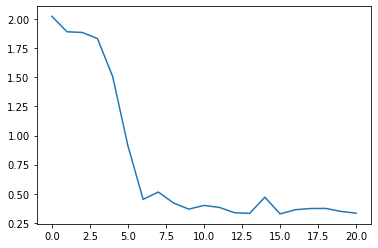

In [27]:
plt.plot(losses)

In [28]:
x = d.sample(128)
model(x, True, True)[1]

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181,
         1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181,
         1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181,
         1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181,
         1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181, 1.4181,
         1.4181, 1.4181, 1.

In [29]:
logDetJ

tensor([ 2.9957,  2.3824,  1.4075,  2.6380,  2.4537,  2.7897,  1.0872,  3.2258,
         2.7515,  3.0031,  3.8107,  2.4990,  2.1129,  3.2408,  2.9731,  2.1699,
         3.1535,  2.2034,  2.9409,  2.8589,  2.5766,  3.7166,  2.6711,  3.6997,
         3.4394,  2.7492,  2.4926,  1.9552,  0.2289,  2.6730,  2.9790,  3.1924,
         2.7001,  2.4237,  2.4570,  2.4341,  2.4962,  2.5621,  2.3508,  2.8931,
         2.0934,  3.2823,  1.8233,  3.6348,  2.8934,  3.8089,  3.3767,  1.0878,
         3.2554,  2.9271,  2.5173,  2.4383,  2.4854,  3.3729,  2.5095,  2.4094,
         2.2830,  1.4765,  2.4378,  2.3127,  2.6076,  2.5995,  2.8562,  2.3528,
         2.1868,  1.3914,  2.6952,  3.3774,  1.0667,  2.1579,  3.3232,  3.1822,
         2.6121,  3.6771,  2.6958,  2.5630,  2.9656,  2.5326,  1.5941,  2.8009,
         2.7828,  1.9314,  1.3121,  2.0921,  2.4652,  2.6587,  2.7437,  2.7973,
         2.2979,  3.0243,  2.7825,  2.0404,  2.9735,  2.6602,  2.5800,  2.5483,
         1.6613,  3.3262,  2.5547,  2.94

tensor(0.3486, grad_fn=<NegBackward>)


Text(0.5, 1.0, 'z -> x')

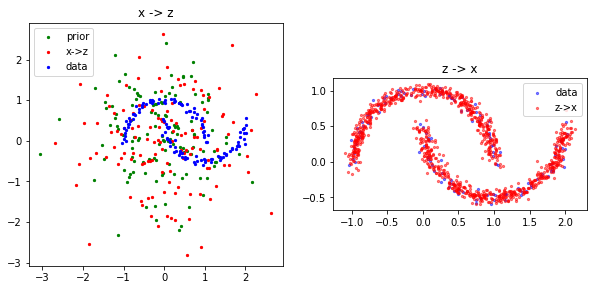

In [30]:
model.eval()

x = d.sample(128)
z, logDetJ, prior_logP = model(x, True)
print(-torch.mean(prior_logP + logDetJ))

x = x.detach().numpy()
z = z.detach().numpy()
p = model.prior.sample((128,))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')

z = model.sample(128*8)
z = z.detach().numpy()
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.5)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


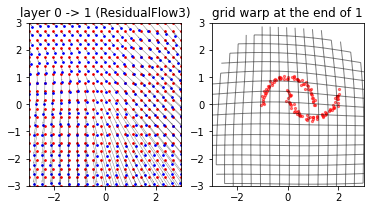

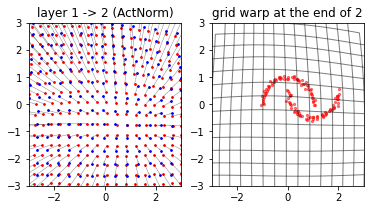

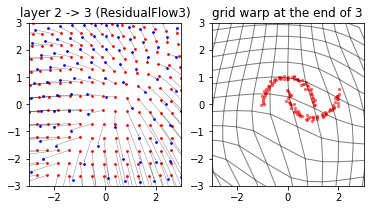

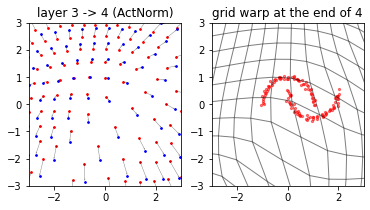

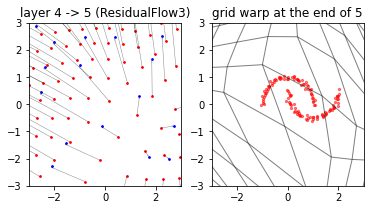

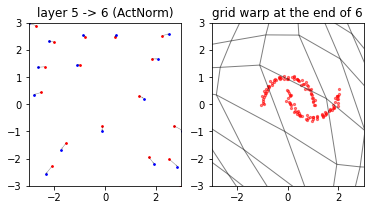

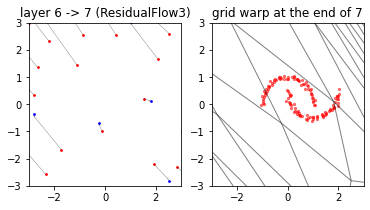

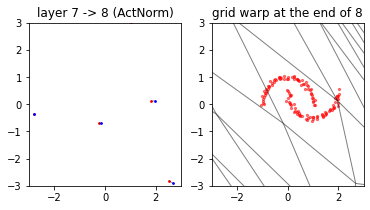

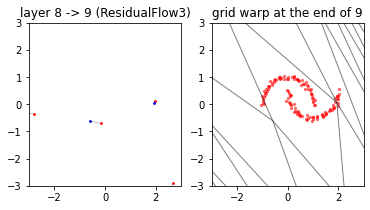

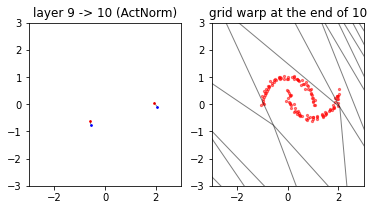

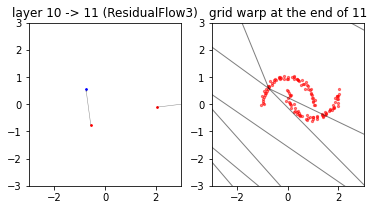

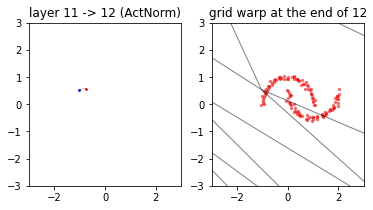

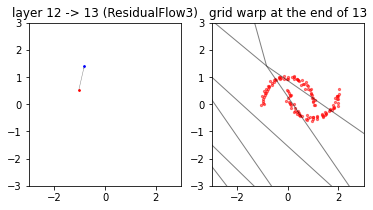

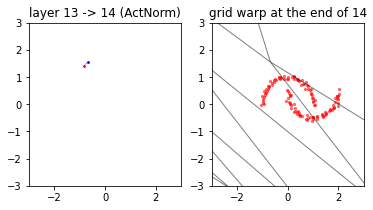

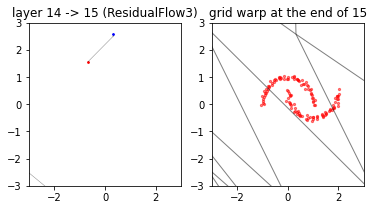

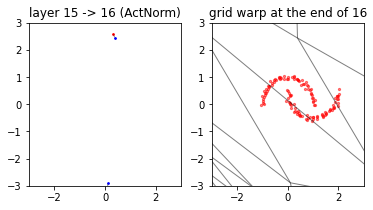

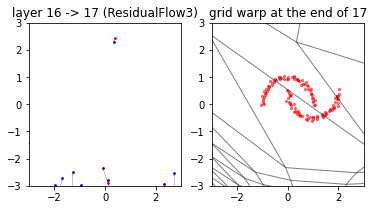

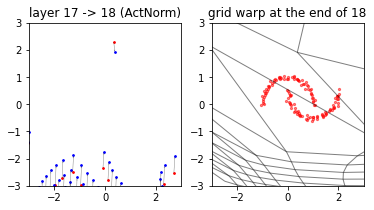

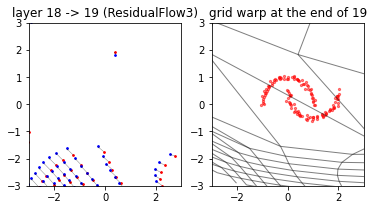

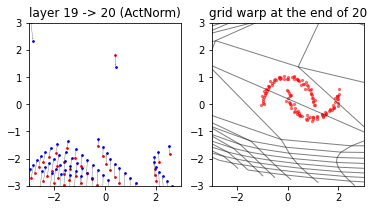

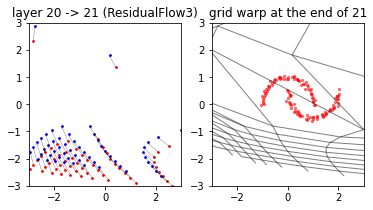

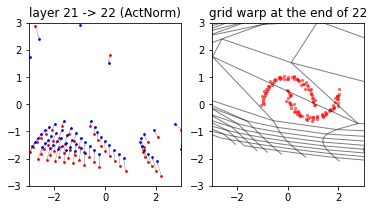

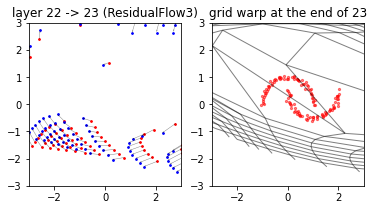

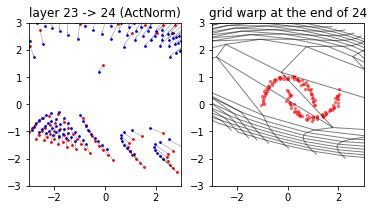

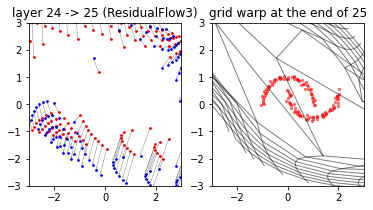

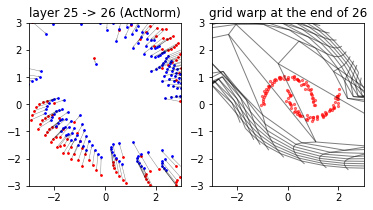

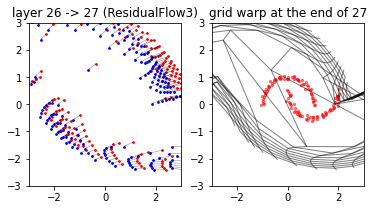

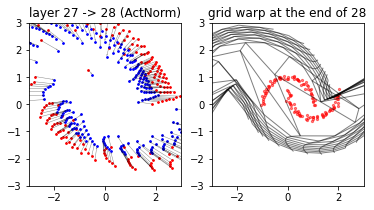

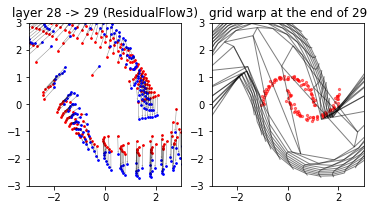

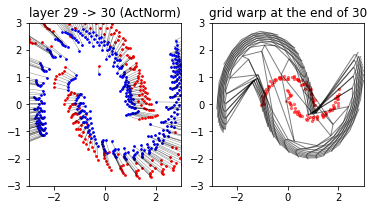

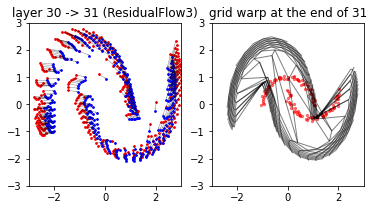

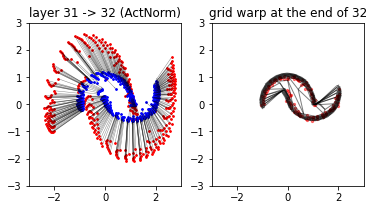

In [31]:
# Visualize the step-wise flow in the full net
from matplotlib import collections  as mc

# plot the coordinate warp
ng = 20
xx, yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(xx, yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3 # seems appropriate since we use radial distributions as priors
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

zs, log_dets = model.inverse(xy, True, intermediate=True)

backward_flow_names = [type(f).__name__ for f in model.flow.flows[::-1]]
nz = len(zs)
for i in range(nz - 1):
    z0 = zs[i].detach().numpy()
    z1 = zs[i+1].detach().numpy()
    
    # plot how the samples travel at this stage
    figs, axs = plt.subplots(1, 2, figsize=(6, 3))
    #plt.figure(figsize=(20,10))
    axs[0].scatter(z0[:,0], z0[:, 1], c='r', s=3)
    axs[0].scatter(z1[:,0], z1[:, 1], c='b', s=3)
    axs[0].quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
    axs[0].axis([-3, 3, -3, 3])
    axs[0].set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
    
    q = z1.reshape((ng, ng, 2))
    # y coords
    p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # x coords
    p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # draw the lines
    axs[1].add_collection(lcy)
    axs[1].add_collection(lcx)
    axs[1].axis([-3, 3, -3, 3])
    axs[1].set_title("grid warp at the end of %d" % (i+1,))
    
    # draw the data too
    plt.scatter(x[:,0], x[:,1], c='r', s=5, alpha=0.5)

In [32]:
# dir(model.flow.flows[0].resblock[0])

In [33]:
# dir(model.flow.flows[0].resblock[0]._forward_pre_hooks[0])

In [ ]:
nn.utils.remove_spectral_norm()